# Feature Engineering

We take the clean dataset (data/cleaned/oil_production_clean.csv) and engineer features.

The idea is to prepare time series features that will enhance the predictive power of the models, mainly those that are capable of having multiple predictors.

* Add temporal components (seasonality, cycles, trend indicators)
* Create lag and rolling window features for autocorrelation learning
* Normalize / scale where appropriate
* Prepare dataset for modeling in notebooks 04–06

### 1. Imports and Load Clean Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load cleaned dataset
df = pd.read_csv("../data/cleaned/oil_production_cleaned.csv")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')
df.head()

,period,MBBL,MBBL/D,rolling_12m
0,1981-01-01,132577,4277,NaN
1,1981-02-01,119414,4265,NaN
2,1981-03-01,132899,4287,NaN
3,1981-04-01,127524,4251,NaN
4,1981-05-01,129558,4179,NaN


### 2.Feature Extraction

#### 2.1 Date-Based Features

In [2]:
df['year'] = df['period'].dt.year
df['month'] = df['period'].dt.month
df['quarter'] = df['period'].dt.quarter
df['dayofyear'] = df['period'].dt.dayofyear
df['weekofyear'] = df['period'].dt.isocalendar().week
df['is_month_start'] = df['period'].dt.is_month_start.astype(int)
df['is_month_end'] = df['period'].dt.is_month_end.astype(int)

#### 2.2 Lag Features (past values)

In [3]:
# 1, 2, 3 month lags, it could be more, but three is enough for now.
for lag in [1, 2, 3]:
    df[f'lag_{lag}'] = df['MBBL/D'].shift(lag)

#### 2.3 Rolling window statistics

In [4]:
# Rolling averages
df['rolling_mean_3'] = df['MBBL/D'].shift(1).rolling(window=3).mean()
df['rolling_mean_6'] = df['MBBL/D'].shift(1).rolling(window=6).mean()
df['rolling_std_3'] = df['MBBL/D'].shift(1).rolling(window=3).std()
df['rolling_std_6'] = df['MBBL/D'].shift(1).rolling(window=6).std()

### 3. Create target variable

In [5]:
df['target'] = df['MBBL/D'].shift(-1)

Predict next month’s MBBL/D based on past + current features

### 4. Remove NaN rows

In [6]:
df = df.dropna().reset_index(drop=True)

### 5.Visualization of engineered features

In [7]:
display(df.head())

,period,MBBL,MBBL/D,rolling_12m,year,month,quarter,dayofyear,weekofyear,is_month_start,is_month_end,lag_1,lag_2,lag_3,rolling_mean_3,rolling_mean_6,rolling_std_3,rolling_std_6,target
0,1981-12-01,129573,4180,4217.500000,1981,12,4,335,49,1,0,4175.0,4185.0,4197.0,4185.666667,4195.166667,11.015141,16.473211,4118.0
1,1982-01-01,127644,4118,4204.250000,1982,1,1,1,53,1,0,4180.0,4175.0,4185.0,4180.000000,4188.666667,5.000000,12.372011,4177.0
2,1982-02-01,116957,4177,4196.916667,1982,2,1,32,5,1,0,4118.0,4180.0,4175.0,4157.666667,4177.333333,34.443190,31.563692,4205.0
3,1982-03-01,130347,4205,4190.083333,1982,3,1,60,9,1,0,4177.0,4118.0,4180.0,4158.333333,4172.000000,34.961884,27.597101,4202.0
4,1982-04-01,126047,4202,4186.000000,1982,4,2,91,13,1,0,4205.0,4177.0,4118.0,4166.666667,4173.333333,44.410960,29.193607,4201.0


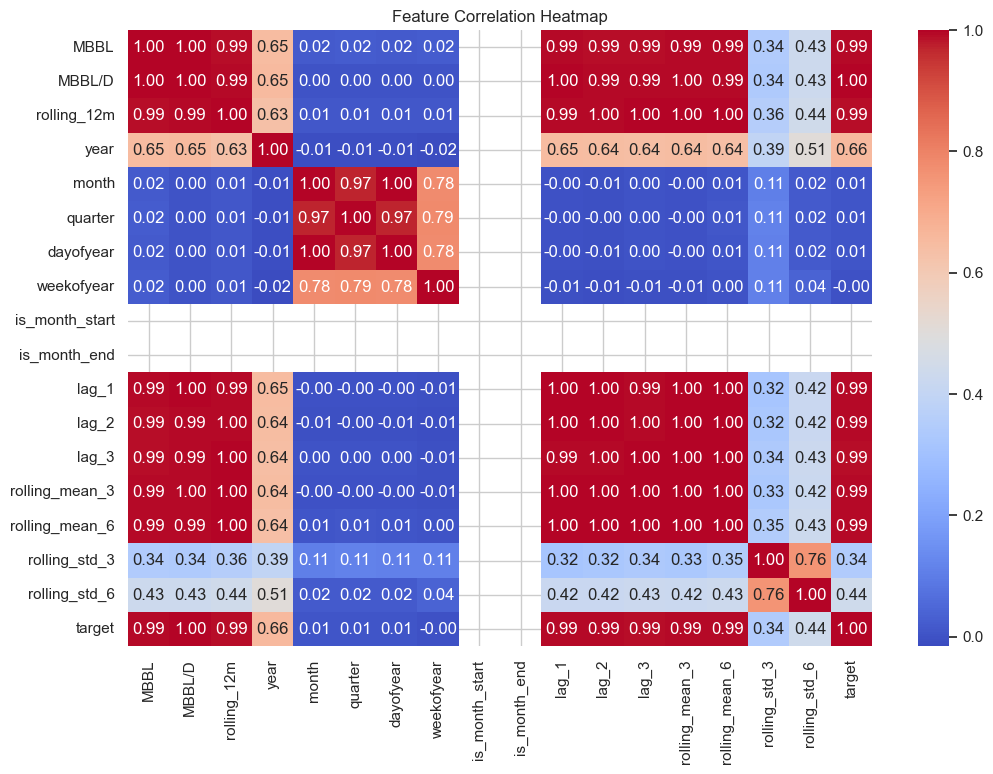

In [17]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In time series for stable industrial processes like oil production, high autocorrelation between lagged and rolling features is expected.
For statistical models (like linear regression), I would either reduce the feature set or use regularization (Lasso, Ridge).
For deep learning or tree-based models, I would keep them all since they are robust to multicollinearity and might extract non-linear interactions.

### 6.Save the dataset created

In [19]:
df.to_csv("../data/processed/oil_production_features.csv", index=False)